## Dictionary and Imports

In [76]:
# Dictionary of users and passwords registered
passwords = {
    0: 'falcon',
    1: 'tiger'
}

In [77]:
import os
import random
import numpy as np
import librosa
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import speech_recognition as sr
import tsfel
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import butter, lfilter
from sklearn.ensemble import RandomForestClassifier

## Audio processing module

This module processes and analyses audio signals for feature extraction, particularly focusing on preprocessing and preparing the data for further analysis. Three functions collectively support audio signal processing workflows in applications.

In [78]:
def preprocess_audio(file_path, low_cutoff=100, high_cutoff=3000):
    """
    Preprocess an audio file by applying a band-pass filter to isolate frequencies
    within the specified range and normalizing the signal.

    Parameters:
    file_path (str): Path to the audio file.
    low_cutoff (float): Lower cutoff frequency for the band-pass filter in Hz. Default is 100 Hz.
    high_cutoff (float): Upper cutoff frequency for the band-pass filter in Hz. Default is 3000 Hz.

    Returns:
    tuple: Filtered audio signal (numpy array) and the sample rate (int).
    """

    signal, sr = librosa.load(file_path, sr=22050)

    # Normalize values between -1 and 1 for uniform processin.
    normalized_signal = librosa.util.normalize(signal)  

    # Design a 5th-order Butterworth band-pass filter.
    nyquist = 0.5 * sr
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(5, [low, high], btype='band')

    filtered_signal = lfilter(b, a, normalized_signal)
    return filtered_signal, sr

def select_test_audio(n):
    """
    Select an audio file from the designated "test" folder. The function can either select
    a file randomly or based on its position in a sorted list of files.

    Parameters:
    n (int): If 0, a random file is selected. If greater than 0, selects the nth file
             (1-based index) from the list of audio files sorted in ascending order.

    Returns:
    str: Full path to the selected audio file.
    """

    test_folder = "./dataset/test" 
    audio_files = [f for f in os.listdir(test_folder) if f.endswith('.wav')]
    audio_files.sort(reverse=True)

    # Raise an error if no audio files are found in the folder.
    if not audio_files:
        raise FileNotFoundError("No audio files found in the 'test' folder.")

    if n == 0:
        selected_file = random.choice(audio_files)
    else:
        if n > len(audio_files):
            raise IndexError(f"The test folder contains only {len(audio_files)} files.")
        
        audio_files.reverse()
        selected_file = audio_files[n - 1]

    # Construct the full path to the selected file.
    file_path = os.path.join(test_folder, selected_file)
    return file_path

def extract_features(file_path):
    """
    Extract MFCC (Mel-frequency cepstral coefficients) and other temporal features
    from an audio file using preprocessing and the TSFEL library.

    Parameters:
    file_path (str): Path to the audio file to be processed.

    Returns:
    tuple, containing:
        - A numpy array of the extracted features.
        - The preprocessed audio signal.
    """

    [y, sr] = preprocess_audio(file_path)

    # Convert the preprocessed signal into a Pandas DataFrame for feature extraction.
    signal_df = pd.DataFrame(y, columns=["Signal"])

    # Get the feature extraction configuration from TSFEL, organized by domain.
    features = tsfel.get_features_by_domain()

    # Extract features from the time series signal using the TSFEL library.
    extracted_features = tsfel.time_series_features_extractor(features, signal_df, sr)
    return extracted_features.to_numpy(), y


## Data preparation module

This module handles the preparation of audio data for training machine learning models. It includes functions to generate file paths for audio files within specific folders, extract features and assign labels to the data based on the speaker's identity. Finally, it combines the features and labels into unified datasets, ready to be used for classification or analysis tasks.

In [79]:
def generate_file_paths(folder_path, extension=[".wav"]):
    """
    Generate a list of absolute file paths for files with specified extensions in a given folder.

    Parameters:
    folder_path (str): The path to the folder containing the files.
    extension (list): A list of file extensions to include (default is [".wav"]).

    Returns:
    list: A list of absolute file paths for matching files.
    """
    
    file_paths = [
        os.path.abspath(os.path.join(folder_path, file))
        for file in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, file)) and os.path.splitext(file)[1].lower() in extension
    ]
    return file_paths

def create_labels_and_features(file_paths, speaker_id):
    """
    Extract features and create labels for a set of audio files.

    Parameters:
    file_paths (list): A list of file paths for the audio files.
    speaker_id (int): The label or identifier for the speaker associated with the audio files.

    Returns:
    tuple: A tuple containing:
        - A numpy array of extracted features for all audio files.
        - A numpy array of labels corresponding to each audio file.
    """

    features = []
    labels = []

    # Loop through each file and extract features and corresponding labels.
    for file_path in file_paths:
        [embedding, y] = extract_features(file_path)  # Extract MFCC features from the audio file.
        features.append(embedding)  
        labels.append(speaker_id) 
    
    return np.array(features), np.array(labels)

# Directory containing subfolders for each class.
dataset_path = 'dataset/registered'

# Initialize lists to store features and labels.
all_features = []
all_labels = []

speakers = {}

# Loop through each subfolder in the dataset directory.
for speaker_id, class_name in enumerate(sorted(os.listdir(dataset_path))):
    class_path = os.path.join(dataset_path, class_name)

    # Ensure it's a directory (to skip any non-directory files).
    if os.path.isdir(class_path):
        speakers[speaker_id] = class_name
        
        # Generate file paths for the current class.
        file_paths = generate_file_paths(class_path)

        # Create features and labels for the current class.
        features, labels = create_labels_and_features(file_paths, speaker_id=speaker_id)

        # Append the features and labels to the main lists.
        all_features.append(features)
        all_labels.append(labels)

# Combine all features and labels into unified datasets for training.
X_train = np.vstack(all_features)
y_train = np.hstack(all_labels)

## Model training

Recognizes who is speaking regardless of content.
Focus on the physical and behavioural properties of the voice.

In [80]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    # n_estimators=100: Number of trees in the forest
    # max_depth=10: Maximum depth of each tree to prevent overfitting
    # random_state=42: Ensures reproducibility of results

n_samples, time_steps, n_features = X_train.shape
X_train_flattened = X_train.reshape(n_samples, time_steps * n_features)

model.fit(X_train_flattened, y_train)   # train the model, result: iperplane

RandomForestClassifier(max_depth=10, random_state=42)

## Password recognition module

The system checks that the person is using their own password and not someone else's. The spoken password is transcribed into text and compared with the registered password of the identified user.

In [81]:
def recognize_password(path_test_audio, correct_password):
    """
    Recognizes a password from an audio file and checks its similarity to the expected password.

    Parameters:
    - audio_file_path (str): The path to the audio file containing the spoken password.
    - prediction (int): An integer indicating which password to use (0 for 'Falcon', 1 for 'Tiger').

    This function uses the Google Web Speech API to transcribe the spoken password and compares it
    to the correct password using fuzzy string matching. A similarity score of 80% or higher is 
    considered a successful match.
    """

    # Initialize the speech recognizer
    recognizer = sr.Recognizer()
    threshold = 80.00

    try:
        with sr.AudioFile(path_test_audio) as source:
            test_audio = recognizer.record(source)

        # Transcribe the audio to text using Google Web Speech API
        recognized_text = recognizer.recognize_google(test_audio)
        print(f"Recognized text: {recognized_text}")

        # Calculate similarity between the recognized text and the correct password
        similarity = fuzz.ratio(recognized_text.lower(), correct_password.lower())

        # Confronta la parola riconosciuta con la password
        if similarity >= threshold:
            print("Password recognized successfully!")
            print("Access allowed!")
        else:
            print("Password does not match...")
            print("Access denied.")
    
    except sr.UnknownValueError:
        print("Sorry, could not understand the audio.")
    except sr.RequestError as e:
        print(f"Error with the speech recognition service: {e}")

## Speaker recognition 

Testing audio: dataset/test/P4/1585-131718-0054.wav
Predicted Speaker: others, Confidence: 0.33, Actual: P4, Correct: False



Testing audio: dataset/test/P4/1585-131718-0036.wav
Predicted Speaker: P4, Confidence: 0.72, Actual: P4, Correct: True



Testing audio: dataset/test/P4/1585-131718-0022.wav
Predicted Speaker: P4, Confidence: 0.93, Actual: P4, Correct: True



Testing audio: dataset/test/P4/1585-157660-0011.wav
Predicted Speaker: others, Confidence: 0.34, Actual: P4, Correct: False



Testing audio: dataset/test/P3/1255-90413-0018.wav
Predicted Speaker: P3, Confidence: 0.85, Actual: P3, Correct: True



Testing audio: dataset/test/P3/1255-90407-0000.wav
Predicted Speaker: P3, Confidence: 0.90, Actual: P3, Correct: True



Testing audio: dataset/test/P3/1255-74899-0012.wav
Predicted Speaker: P3, Confidence: 0.60, Actual: P3, Correct: True



Testing audio: dataset/test/P3/1255-74899-0000.wav
Predicted Speaker: P3, Confidence: 0.96, Actual: P3, Correct: True



Testing audio: dataset/test/P2/700-122866-0011.wav
Predicted Speaker: P2, Confidence: 0.61, Actual: P2, Correct: True



Testing audio: dataset/test/P2/700-122867-0005.wav
Predicted Speaker: P2, Confidence: 0.76, Actual: P2, Correct: True



Testing audio: dataset/test/P2/700-122866-0029.wav
Predicted Speaker: P2, Confidence: 0.42, Actual: P2, Correct: True



Testing audio: dataset/test/P2/700-122867-0029.wav
Predicted Speaker: P2, Confidence: 0.38, Actual: P2, Correct: True



Testing audio: dataset/test/P5/1630-102884-0001.wav
Predicted Speaker: P5, Confidence: 0.84, Actual: P5, Correct: True



Testing audio: dataset/test/P5/1630-73710-0010.wav
Predicted Speaker: P5, Confidence: 0.93, Actual: P5, Correct: True



Testing audio: dataset/test/P5/1630-73710-0020.wav
Predicted Speaker: P5, Confidence: 0.77, Actual: P5, Correct: True



Testing audio: dataset/test/P5/1630-141772-0020.wav
Predicted Speaker: P5, Confidence: 0.44, Actual: P5, Correct: True



Testing audio: dataset/test/others/cat1.wav
Predicted Speaker: others, Confidence: 0.52, Actual: others, Correct: True



Testing audio: dataset/test/others/dog1.wav
Predicted Speaker: others, Confidence: 0.44, Actual: others, Correct: True



Testing audio: dataset/test/others/dog2.wav
Predicted Speaker: others, Confidence: 0.40, Actual: others, Correct: True



Testing audio: dataset/test/others/dog3.wav
Predicted Speaker: P7, Confidence: 0.33, Actual: others, Correct: False



Testing audio: dataset/test/others/others3.wav
Predicted Speaker: others, Confidence: 0.63, Actual: others, Correct: True



Testing audio: dataset/test/others/bird2.wav
Predicted Speaker: others, Confidence: 0.54, Actual: others, Correct: True



Testing audio: dataset/test/others/others2.wav
Predicted Speaker: others, Confidence: 0.58, Actual: others, Correct: True



Testing audio: dataset/test/others/bird1.wav
Predicted Speaker: others, Confidence: 0.36, Actual: others, Correct: True



Testing audio: dataset/test/others/others1.wav
Predicted Speaker: others, Confidence: 0.42, Actual: others, Correct: True



Testing audio: dataset/test/others/others5.wav
Predicted Speaker: others, Confidence: 0.39, Actual: others, Correct: True



Testing audio: dataset/test/others/others4.wav
Predicted Speaker: others, Confidence: 0.70, Actual: others, Correct: True



Testing audio: dataset/test/others/others6.wav
Predicted Speaker: others, Confidence: 0.33, Actual: others, Correct: True



Testing audio: dataset/test/others/luca_random2.wav
Predicted Speaker: others, Confidence: 0.38, Actual: others, Correct: True



Testing audio: dataset/test/others/pedro_falcon.wav
Predicted Speaker: andre, Confidence: 0.50, Actual: others, Correct: False

Recognized text: falcon
Password does not match...
Access denied.


Testing audio: dataset/test/P7/1686-142278-0077.wav
Predicted Speaker: P7, Confidence: 0.51, Actual: P7, Correct: True



Testing audio: dataset/test/P7/1686-142278-0047.wav
Predicted Speaker: P7, Confidence: 0.86, Actual: P7, Correct: True



Testing audio: dataset/test/P7/1686-142278-0092.wav
Predicted Speaker: P7, Confidence: 0.59, Actual: P7, Correct: True



Testing audio: dataset/test/P7/1686-142278-0021.wav
Predicted Speaker: P7, Confidence: 0.78, Actual: P7, Correct: True



Testing audio: dataset/test/P8/1701-141759-0011.wav
Predicted Speaker: P8, Confidence: 0.63, Actual: P8, Correct: True



Testing audio: dataset/test/P8/1701-141760-0010.wav
Predicted Speaker: P3, Confidence: 0.27, Actual: P8, Correct: False



Testing audio: dataset/test/P8/1701-141760-0008.wav
Predicted Speaker: P8, Confidence: 0.50, Actual: P8, Correct: True



Testing audio: dataset/test/P8/1701-141759-0030.wav
Predicted Speaker: P8, Confidence: 0.55, Actual: P8, Correct: True



Testing audio: dataset/test/P6/1650-167613-0054.wav
Predicted Speaker: P6, Confidence: 0.84, Actual: P6, Correct: True



Testing audio: dataset/test/P6/1650-167613-0022.wav
Predicted Speaker: P6, Confidence: 0.95, Actual: P6, Correct: True



Testing audio: dataset/test/P6/1650-167613-0006.wav
Predicted Speaker: P6, Confidence: 0.96, Actual: P6, Correct: True



Testing audio: dataset/test/P6/1650-173551-0007.wav
Predicted Speaker: P6, Confidence: 0.69, Actual: P6, Correct: True



Testing audio: dataset/test/P1/116-288045-0020.wav
Predicted Speaker: P1, Confidence: 0.99, Actual: P1, Correct: True



Testing audio: dataset/test/P1/116-288047-0002.wav
Predicted Speaker: P1, Confidence: 0.92, Actual: P1, Correct: True



Testing audio: dataset/test/P1/116-288047-0015.wav
Predicted Speaker: P1, Confidence: 1.00, Actual: P1, Correct: True



Testing audio: dataset/test/P1/116-288046-0008.wav
Predicted Speaker: P1, Confidence: 1.00, Actual: P1, Correct: True



Testing audio: dataset/test/arianna/arianna_random.wav
Predicted Speaker: arianna, Confidence: 0.76, Actual: arianna, Correct: True

Recognized text: red cabin is for emergency
Password does not match...
Access denied.


Testing audio: dataset/test/arianna/arianna_pw2.wav
Predicted Speaker: arianna, Confidence: 0.85, Actual: arianna, Correct: True

Recognized text: falcon
Password recognized successfully!
Access allowed!


Testing audio: dataset/test/arianna/arianna_pw1.wav
Predicted Speaker: arianna, Confidence: 0.93, Actual: arianna, Correct: True

Recognized text: falcon
Password recognized successfully!
Access allowed!


Testing audio: dataset/test/andre/andre_random2.wav
Predicted Speaker: andre, Confidence: 0.85, Actual: andre, Correct: True

Recognized text: yeah this is the last one I think it's done
Password does not match...
Access denied.


Testing audio: dataset/test/andre/andre_pw1.wav
Predicted Speaker: andre, Confidence: 0.83, Actual: andre, Correct: True

Recognized text: tiger
Password recognized successfully!
Access allowed!


Testing audio: dataset/test/andre/andre_random.wav
Predicted Speaker: andre, Confidence: 0.67, Actual: andre, Correct: True

Recognized text: I'm lost
Password does not match...
Access denied.

Overall Accuracy: 90.38%


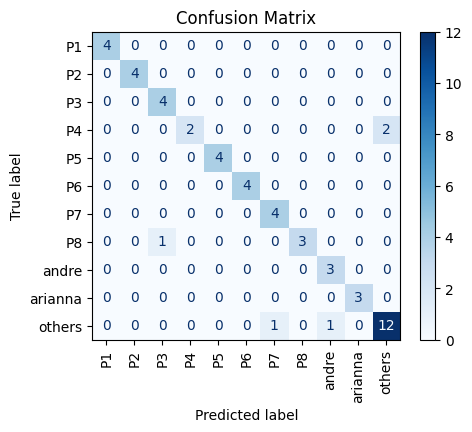


Classification Report:

              precision    recall  f1-score   support

          P1       1.00      1.00      1.00         4
          P2       1.00      1.00      1.00         4
          P3       0.80      1.00      0.89         4
          P4       1.00      0.50      0.67         4
          P5       1.00      1.00      1.00         4
          P6       1.00      1.00      1.00         4
          P7       0.80      1.00      0.89         4
          P8       1.00      0.75      0.86         4
       andre       0.75      1.00      0.86         3
     arianna       1.00      1.00      1.00         3
      others       0.86      0.86      0.86        14

    accuracy                           0.90        52
   macro avg       0.93      0.92      0.91        52
weighted avg       0.92      0.90      0.90        52



In [82]:
# Directory containing test audio subfolders.
test_dataset_path = 'dataset/test'

# Set confidence threshold for speaker recognition
threshold = 0.50

# Initialize counters for evaluation
correct_predictions = 0
total_predictions = 0

# Iterate through each class folder in the test dataset
test_results = []  # To store detailed test results

for class_name in os.listdir(test_dataset_path):
    class_path = os.path.join(test_dataset_path, class_name)

    # Ensure it's a directory
    if os.path.isdir(class_path):
        
        # Iterate through each test audio file in the class folder
        for test_file in os.listdir(class_path):
            path_test_audio = os.path.join(class_path, test_file)
            
            if test_file.startswith('.'):
                continue

            # Extract MFCC features and the processed audio from the test file
            test_embedding, test_audio = extract_features(path_test_audio)

            # Reshape the MFCC features to match model input shape
            test_embedding_reshaped = test_embedding.reshape(1, -1)

            # Predict probabilities and confidence
            probabilities = model.predict_proba(test_embedding_reshaped)[0]
            prediction = np.argmax(probabilities)       # Speaker predicted
            confidence = probabilities[prediction]      # Confidence

            # Map the predicted index to the speaker's name
            predicted_speaker = speakers.get(prediction+1, 'not registered')

            # Check if the prediction matches the actual class
            is_correct = True if predicted_speaker == class_name else False

            # Update counters
            total_predictions += 1
            if is_correct:
                correct_predictions += 1

            # Store the result for logging
            test_results.append({
                'file': test_file,
                'actual': class_name,
                'predicted': predicted_speaker,
                'confidence': confidence,
                'correct': is_correct
            })

            # Print results for each test file
            print(f"Testing audio: {path_test_audio}")
            print(f"Predicted Speaker: {predicted_speaker}, Confidence: {confidence:.2f}, Actual: {class_name}, Correct: {is_correct}\n")

            if predicted_speaker == 'arianna' or predicted_speaker == 'andre':
                correct_password = 'falcon' if predicted_speaker == 'arianna' else 'tiger'
                recognize_password(path_test_audio, correct_password)

# Calculate overall accuracy
accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
print(f"\nOverall Accuracy: {accuracy:.2f}%")

# Dopo aver accumulato i risultati nel test_results:
actual_labels = [result['actual'] for result in test_results]
predicted_labels = [result['predicted'] for result in test_results]

# Creazione della confusion matrix
labels = sorted(set(actual_labels))  # Ordina i nomi delle classi
cm = confusion_matrix(actual_labels, predicted_labels, labels=labels)

# Visualizzazione della confusion matrix
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.title("Confusion Matrix")
plt.show()

report = classification_report(actual_labels, predicted_labels, labels=labels, target_names=labels)
print("\nClassification Report:\n")
print(report)

In [83]:
# Dictionary to store accuracy for each class
class_accuracies = {class_name: {"correct": 0, "total": 0} for class_name in os.listdir(test_dataset_path) if os.path.isdir(os.path.join(test_dataset_path, class_name))}

for result in test_results:
    actual = result['actual']
    is_correct = result['correct']
    class_accuracies[actual]["total"] += 1
    if is_correct:
        class_accuracies[actual]["correct"] += 1

# Calculate the accuracy for each class
class_accuracy_percentages = {}
for class_name, stats in class_accuracies.items():
    if stats["total"] > 0:
        accuracy = stats["correct"] / stats["total"]
    else:
        accuracy = 0
    class_accuracy_percentages[class_name] = accuracy

# Calculate the mean accuracy across all classes
mean_accuracy = sum(class_accuracy_percentages.values()) / len(class_accuracy_percentages)

# Save results to a file
results_file = "accuracy_results.txt"
with open(results_file, "a") as file:
    file.write(f"Number of classes: {len(class_accuracy_percentages)}\n")
    for class_name, accuracy in class_accuracy_percentages.items():
        file.write(f"{class_name}: {accuracy:.2f}\n")
    file.write(f"Mean Accuracy: {mean_accuracy:.2f}\n")
    file.write("-" * 40 + "\n")

print(f"Results saved to {results_file}")

Results saved to accuracy_results.txt


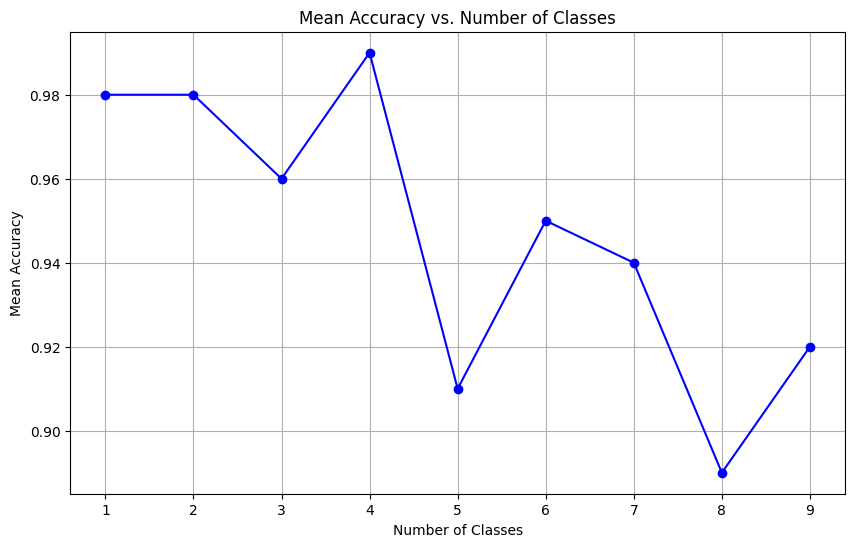

In [84]:
# Read accuracies from the results file
history_file = "accuracy_results.txt"
accuracies_over_time = []
with open(history_file, "r") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("Mean Accuracy"):
            accuracies_over_time.append(float(line.split(":")[1].strip()))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies_over_time) + 1), accuracies_over_time, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Classes")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy vs. Number of Classes")
plt.grid()
plt.xticks(range(1, len(accuracies_over_time) + 1))
plt.show()